# Introduction to Crunchers

In this notebook we demonstrate crunchers, silicone's most fundamental infilling methods. You will need to install silicone from as described in the readme in order to run this code. It introduces two specific crunchers and the basic tools to manipulate them. These two are the 'closest RMS' and the 'rolling window quantile' crunchers. 

## Imports

In [1]:
import os.path
import traceback

import pandas as pd
import pyam
import matplotlib.pyplot as plt
import numpy as np

import silicone.database_crunchers
from silicone.utils import (
    _get_unit_of_variable,
    find_matching_scenarios,
    _make_interpolator,
    _make_wide_db, 
    get_sr15_scenarios
)

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


## Assembling example data

Here we pull some example data by downloading a selection of the SR1.5 scenarios from the IIASA database. If the data has already been downloaded before, we will use that instead for brevity. We select only a few cases

In [2]:
valid_model_ids = [
        "MESSAGE*",
        "AIM*",
        "C-ROADS*",
        "GCAM*",
        #"IEA*",
        #"IMAGE*",
        #"MERGE*",
        #"POLES*",
        #"REMIND*",
        "WITCH*"
    ]
SR15_SCENARIOS = "./sr15_scenarios.csv"
if not os.path.isfile(SR15_SCENARIOS):
    get_sr15_scenarios(SR15_SCENARIOS, valid_model_ids)

### Starting point

Our starting point is the test data, loaded a `pyam.IamDataFrame`. It may be helpful for understanding some of this tutorial for you to know more about IamDataFrames, documented at https://pyam-iamc.readthedocs.io/en/latest/. The key functions are `.filter()`, which selects a subset of data, and `.timeseries()`, which restructures the data into columns by date, with long indexes containing information other than the value. 

In [3]:
sr15_data = pyam.IamDataFrame(SR15_SCENARIOS)
sr15_data.timeseries().head()

pyam.utils - INFO: Reading `./sr15_scenarios.csv`


2000  \
model       scenario               region variable                                           unit      meta subannual         
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0    0.0         NaN   
                                          Emissions|CH4                                      Mt CH4/yr 0    0.0         NaN   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr 0    0.0         NaN   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr 0    0.0         NaN   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr 0    0.0         NaN   

                                                                                                                           2005  \
model       scenario               region variable                                           unit      meta subannual             
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0    0.0          8.3367   
                                          Emissions|CH4                                      Mt CH4/yr 0    0.0        344.9167   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr 0    0.0        167.6717   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr 0    0.0          0.4732   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr 0    0.0         11.2639   

                                                                                                                           2010  \
model       scenario               region variable                                           unit      meta subannual             
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0    0.0          7.6408   
                                          Emissions|CH4                                      Mt CH4/yr 0    0.0        367.7457   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr 0    0.0        179.6356   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr 0    0.0          0.5168   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr 0    0.0         11.1249   

                                                                                                                       2014  \
model       scenario               region variable                                           unit      meta subannual         
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0    0.0         NaN   
                                          Emissions|CH4                                      Mt CH4/yr 0    0.0         NaN   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr 0    0.0         NaN   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr 0    0.0         NaN   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr 0    0.0         NaN   

                                                                                                                           2015  \
model       scenario               region variable                                           unit      meta subannual             
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0    0.0          7.2724   
                                          Emissions|CH4                                      Mt CH4/yr 0    0.

## Crunchers

Silicone's 'crunchers' are used to determine the relationship between a 'follower variable' and 'lead variable(s)' from a given database. The 'follower variable' is the variable for which we want to generate data e.g. `Emissions|C3F8` while the 'lead variable(s)' is the variable we want to use in order to infer a timeseries of the 'follower variable'. The lead variable is typically a list with only a single item, e.g. `[Emissions|C3F8]` but might be a more complex combination of gases e.g. CO$_2$, CH$_4$ and N$_2$O. 

Each cruncher needs to be initialised with a database and has a `derive_relationship` method, which returns the infilling function. Its docstring describes what it does.

In [11]:
print(silicone.database_crunchers.base._DatabaseCruncher.derive_relationship.__doc__)
# # an alternative, pop-up interface is shown if you uncomment the line below
#silicone.database_crunchers.base._DatabaseCruncher.derive_relationship?


        Derive the relationship between two variables from the database

        Parameters
        ----------
        variable_follower : str
            The variable for which we want to calculate timeseries (e.g.
            ``"Emissions|C5F12"``).

        variable_leaders : list[str]
            The variables we want to use in order to infer timeseries of
            ``variable_follower`` (e.g. ``["Emissions|CO2", "Emissions|CH4"]``)

        **kwargs
            Keyword arguments used by this class to derive the relationship between
            ``variable_follower`` and ``variable_leaders``.

        Returns
        -------
        :obj:`func`
            Function which takes a :obj:`pyam.IamDataFrame` containing
            ``variable_leaders`` timeseries and returns timeseries for
            ``variable_follower`` based on the derived relationship between the two.
            Please see the source code for the exact definition (and docstring) of the
            returned functi

These crunchers are best explored by looking at the examples below.

### Closest Root Mean Square cruncher

This cruncher finds the scenario and model in the infiller database that minimises the RMS distance between the the lead emissions in the infiller and infillee data. The follow data is then directly taken from that scenario. 
The full documentation is as follows:

In [7]:
print(silicone.database_crunchers.DatabaseCruncherRMSClosest.__doc__)


    Database cruncher which uses the 'closest RMS' technkque.

    This cruncher derives the relationship between two variables by finding the
    scenario which has the closest lead gas timeseries in the database.  The follower
    gas timeseries is then simply copied from the closest scenario.

    Here, 'closest' is defined as the smallest time-averaged root mean squared (L2)
    difference.

    .. math::
        RMS = \left ( \frac{1}{n} \sum_{t=0}^n (E_l(t) - E_l^{d}(t))^2 \right )^{1/2}

    where :math:`n` is the total number of timesteps in the lead gas' timeseries,
    :math:`E_l(t)` is the lead gas emissions timeseries and :math:`E_l^d(t)` is a lead
    gas emissions timeseries in the database.
    


#### Infilling

Firstly, let's cut the database down to a size that is comprehensible.

In [12]:
sr15_data_closest_rms = sr15_data.filter(model=["WITCH-GLOBIOM 4.2"])

Next, we initialise the type of cruncher we want with the infiller database. 

In [14]:
cruncher = silicone.database_crunchers.DatabaseCruncherRMSClosest(sr15_data_closest_rms)

Now we can derive the relationship between e.g. `Emissions|CO2` and `Emissions|VOC` in the infiller data.

In [15]:
filler = cruncher.derive_relationship("Emissions|VOC", ["Emissions|CO2"])
print(filler.__doc__)
# filler info:


            Filler function derived from :obj:`DatabaseCruncherRMSClosest`.

            Parameters
            ----------
            in_iamdf : :obj:`pyam.IamDataFrame`
                Input data to fill data in

            Returns
            -------
            :obj:`pyam.IamDataFrame`
                Filled in data (without original source data)

            Raises
            ------
            ValueError
                If there are any inconsistencies between the timeseries, units or
                expectations of the program and ``in_iamdf``, compared to the database
                used to generate this ``filler`` function.
            


Finally we can use this relationship to do some infilling. As a sanity check, we firstly make sure that if we pass in a CO$_2$ timeseries which is already in the database, we get back its VOC emissions timeseries. 

In [16]:
example_model_scen = {
    "model": "WITCH-GLOBIOM 4.2",
    "scenario": "ADVANCE_INDC",
}
example_input = sr15_data_closest_rms.filter(**example_model_scen).data
example_input["model"] = "example"
example_input["scenario"] = "example"
example_input = pyam.IamDataFrame(example_input)

We can now use the function we returned above to infill the example data, and see that we recover the data we put in. 

In [19]:
example_input_filled = filler(example_input)
example_input_filled.timeseries()

,,,,,,,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
model,scenario,region,variable,unit,meta,subannual,,,,,,,,,,,,,,,,,,,,
example,example,World,Emissions|VOC,Mt VOC/yr,0,0.0,189.212,164.056724,153.575866,145.611005,130.387433,115.465871,102.038923,89.302542,76.60488,62.855685,58.440154,56.971497,55.075327,53.101911,51.074418,49.558506,47.602518,45.377459,43.08547,41.400122


In [20]:
sr15_data_closest_rms.filter(variable="Emissions|VOC", **example_model_scen).timeseries()

,,,,,,,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
model,scenario,region,variable,unit,meta,subannual,,,,,,,,,,,,,,,,,,,,
WITCH-GLOBIOM 4.2,ADVANCE_INDC,World,Emissions|VOC,Mt VOC/yr,0,0.0,189.212,164.056724,153.575866,145.611005,130.387433,115.465871,102.038923,89.302542,76.60488,62.855685,58.440154,56.971497,55.075327,53.101911,51.074418,49.558506,47.602518,45.377459,43.08547,41.400122


As expected, the cruncher has picked out the scenario which matches and returned its VOC timeseries. This can also be seen in a plot below, where the dashed line perfectly matches the pink line. 

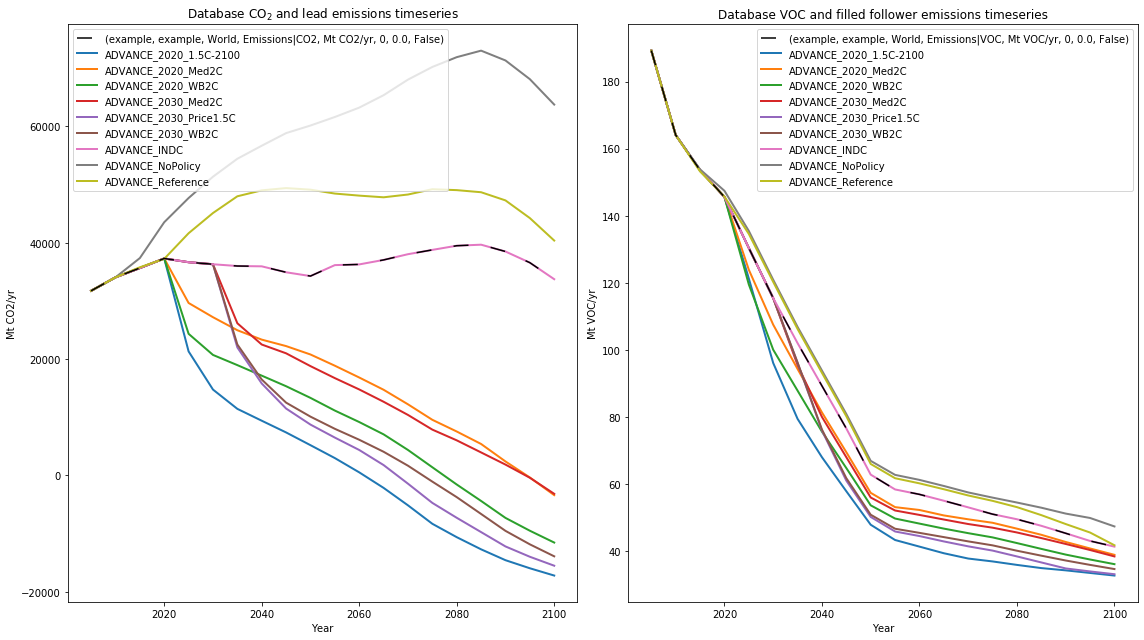

In [21]:
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_closest_rms.filter(variable="*CO2").line_plot(ax=ax, **pkwargs)
example_input.filter(variable="*CO2").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15))
ax.set_title("Database CO$_2$ and lead emissions timeseries")

ax = fig.add_subplot(122)
sr15_data_closest_rms.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
example_input_filled.filter(variable="*VOC").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15))
ax.set_title("Database VOC and filled follower emissions timeseries")

plt.tight_layout()

Now we can use our filler to infill other timeseries not present in our infiller database.

In [22]:
filler_input = sr15_data.filter(model="MESSAGEix-GLOBIOM 1.0", scenario="CD-LINKS_NPi2020_1600")

In [23]:
filler_input = sr15_data.filter(model="MESSAGEix-GLOBIOM 1.0", scenario="CD-LINKS_NPi2020_1600")
# This scenario is missing `Emissions|VOC`. 
filler_input.filter(variable="Emissions|VOC").data

pyam.core - WARNING: Filtered IamDataFrame is empty!


,model,scenario,region,variable,unit,year,meta,subannual,value


In [24]:
# It can go in the same infiller we defined previously.
filler_input_filled = filler(filler_input)

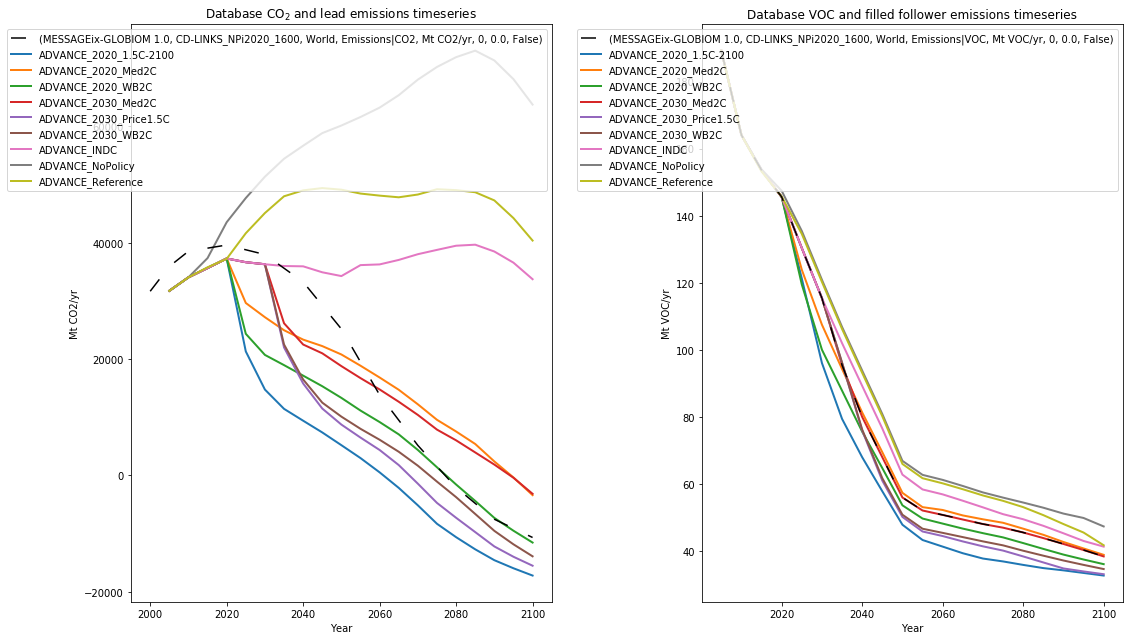

In [25]:
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_closest_rms.filter(variable="*CO2").line_plot(ax=ax, **pkwargs)
# sr15_data_closest_rms.filter(variable="*CO2", **example_model_scen).line_plot(ax=ax, color="black")
filler_input.filter(variable="*CO2").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15))
ax.set_title("Database CO$_2$ and lead emissions timeseries")

ax = fig.add_subplot(122)
sr15_data_closest_rms.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
filler_input_filled.filter(variable="*VOC").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15))
ax.set_title("Database VOC and filled follower emissions timeseries")

plt.tight_layout()

As we can see, on an RMS basis our input timeseries is closest to the 'ADVANCE_2030_Med2C' scenario and hence its `Emissions|VOC` pathway is returned.

In [26]:
filler_input_filled.timeseries()

,,,,,,,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
model,scenario,region,variable,unit,meta,subannual,,,,,,,,,,,,,,,,,,,,
MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,0,0.0,189.212,164.056724,153.575866,145.611005,130.387433,115.465871,95.506957,80.043895,68.04429,56.038428,52.164286,50.849028,49.479184,48.134296,47.046133,45.615107,43.948576,42.192038,40.390822,38.480263


In [27]:
sr15_data_closest_rms.filter(scenario="ADVANCE_2030_Med2C", variable="Emissions|VOC").timeseries()

,,,,,,,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
model,scenario,region,variable,unit,meta,subannual,,,,,,,,,,,,,,,,,,,,
WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,0,0.0,189.212,164.056724,153.575866,145.611005,130.387433,115.465871,95.506957,80.043895,68.04429,56.038428,52.164286,50.849028,49.479184,48.134296,47.046133,45.615107,43.948576,42.192038,40.390822,38.480263


This may be regarded as conceptually the simplest of the crunchers. We will introduce one other in this workbook, and then several in the next. 

### Rolling Window Quantile cruncher

This cruncher uses the 'rolling window quantile' methodology. It is described by its docstring.

In [22]:
print(silicone.database_crunchers.DatabaseCruncherQuantileRollingWindows.__doc__)
# silicone.database_crunchers.DatabaseCruncherQuantileRollingWindows?


    Database cruncher which uses the 'rolling windows' technique.

    This cruncher derives the relationship between two variables by performing
    quantile calculations between the follower timeseries and the lead timeseries.
    These calculations are performed at each timestep in the timeseries, independent
    of the other timesteps.

    For each timestep, the lead timeseries axis is divided into multiple evenly spaced
    windows (to date this is only tested on 1:1 relationships but may work with more
    than one lead timeseries). In each window, every data point in the database is
    included. However, the data points receive a weight given by

    .. math::

        w(x, x_{\text{window}}) = \frac{1}{1 + (d_n)^2}

    where :math:`w` is the weight and :math:`d_n` is the normalised distance between
    the centre of the window and the data point's position on the lead timeseries axis.

    :math:`d_n` is calculated as

    .. math::

        d_n = \frac{x - x_{\text{window}

#### Infilling

Because it relies on quantile analysis, this database does best with large amounts of data. Hence we keep quite a lot of emissions timeseries before beginning.

In [23]:
sr15_data_quantile = sr15_data.copy().filter(
    model=["WITCH-GLOBIOM 4.2"], variable=["Emissions|CO2", "Emissions|VOC"]
)

In [24]:
cruncher = silicone.database_crunchers.DatabaseCruncherQuantileRollingWindows(sr15_data_quantile)

In [25]:
filler = cruncher.derive_relationship("Emissions|VOC", ["Emissions|CO2"])
print(filler.__doc__)
# filler?


            Filler function derived from :obj:`DatabaseCruncherQuantileRollingWindows`.

            Parameters
            ----------
            in_iamdf : :obj:`pyam.IamDataFrame`
                Input data to fill data in

            Returns
            -------
            :obj:`pyam.IamDataFrame`
                Filled in data (without original source data)

            Raises
            ------
            ValueError
                The key db_times for filling are not in ``in_iamdf``.
            


Now we can infill.

In [26]:
filler_data = sr15_data.filter(
    model="MESSAGEix-GLOBIOM 1.0", 
    scenario="CD-LINKS_NPi2020_1600", 
    variable=["Emissions|CO2"]
)

The `filler_data` is missing `Emissions|VOC`.

In [27]:
#NBVAL_IGNORE_OUTPUT
filler_data.filter(variable="Emissions|VOC").data

pyam.core - WARNING: Filtered IamDataFrame is empty!


,model,scenario,region,variable,unit,year,meta,subannual,value


The rolling windows quantile can only downscale on the timesteps in the database. If this isn't the case, we will receive a `ValueError`.

In [28]:
try:
    filler(filler_data)
except ValueError:
    traceback.print_exc(limit=0, chain=False)

Traceback (most recent call last):
ValueError: Not all required timepoints are present in the database we crunched, we crunched 
	`[2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100]`
but you passed in 
	[2000, 2005, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]


We can fix this by filtering first.

In [29]:
# NBVAL_IGNORE_OUTPUT
filler_data = filler_data.filter(year=sr15_data_quantile["year"].unique())

In [30]:
#NBVAL_IGNORE_OUTPUT
filler_data.timeseries()

,,,,,,,2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
model,scenario,region,variable,unit,meta,subannual,,,,,,,,,,,
MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|CO2,Mt CO2/yr,0,0.0,35933.0697,38542.01816,39615.22255,37981.07524,33271.92656,25181.95619,13847.19271,5163.226383,-2068.503671,-7525.726077,-10662.64286


In [31]:
#NBVAL_IGNORE_OUTPUT
filler_data_filled = filler(filler_data)
filler_data_filled.head()

,model,scenario,region,variable,unit,year,subannual,meta,value
0,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2005,0.0,0,189.212000
1,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2010,0.0,0,164.056724
2,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2020,0.0,0,145.611005
3,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2030,0.0,0,115.465871
4,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2040,0.0,0,89.302542


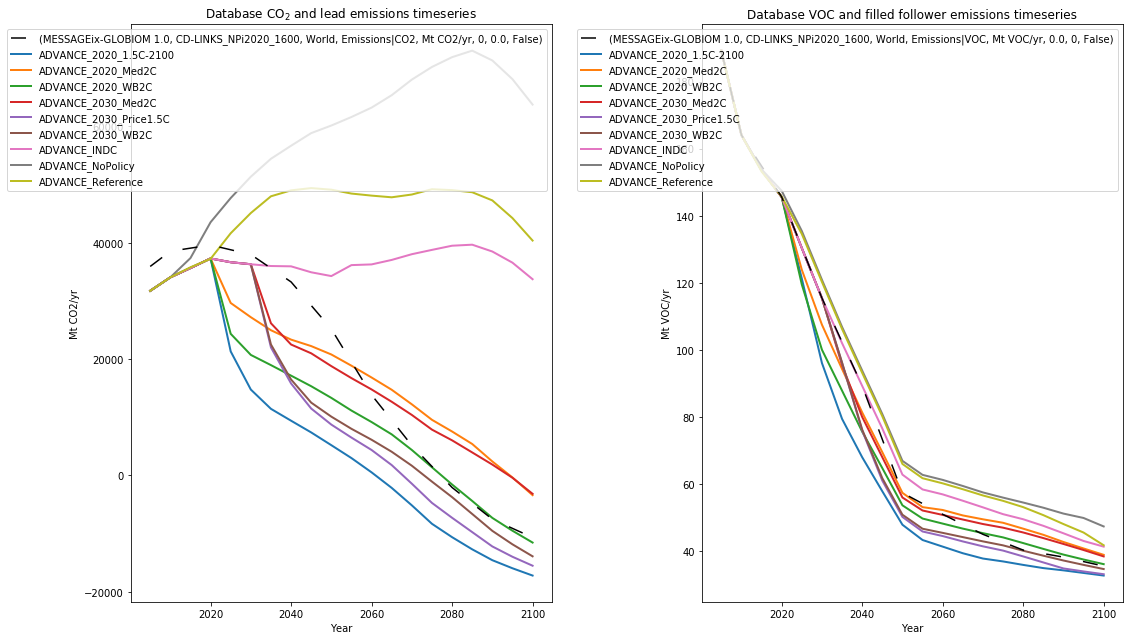

In [32]:
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_quantile.filter(variable="*CO2").line_plot(ax=ax, **pkwargs)
# sr15_data_closest_rms.filter(variable="*CO2", **example_model_scen).line_plot(ax=ax, color="black")
filler_data.filter(variable="*CO2").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15))
ax.set_title("Database CO$_2$ and lead emissions timeseries")

ax = fig.add_subplot(122)
sr15_data_quantile.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
filler_data_filled.filter(variable="*VOC").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15))
ax.set_title("Database VOC and filled follower emissions timeseries")

plt.tight_layout()

#### Recovering the data you put in

Because of the averaging mechanism, the cruncher will only precisely reproduce the input data when only one timeseries is put into it. With multiple data series, this is not guaranteed, although will happen in the limit case of many windows. 

This section does not illustrate new functionality, merely investigates the mathematical effects of changing the number of windows.

In [33]:
# NBVAL_IGNORE_OUTPUT
# Multiple data are input - the 50th percentile and nwindows=10 is the default
filler_data = sr15_data_quantile.filter(scenario='ADVANCE_2030_Med2C')
self_cruncher = silicone.database_crunchers.DatabaseCruncherQuantileRollingWindows(sr15_data)
self_filler_default = self_cruncher.derive_relationship("Emissions|VOC", ["Emissions|VOC"], nwindows=10)
infilled_quantile = self_filler_default(filler_data)
infilled_quantile.head()

,model,scenario,region,variable,unit,year,meta,subannual,value
0,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2005,0,0.0,192.070847
1,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2010,0,0.0,161.751368
2,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2015,0,0.0,153.277468
3,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2020,0,0.0,145.844938
4,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2025,0,0.0,127.431849


The default behaviour shows the correct trend, but the windows-based interpolation introduces some noise.

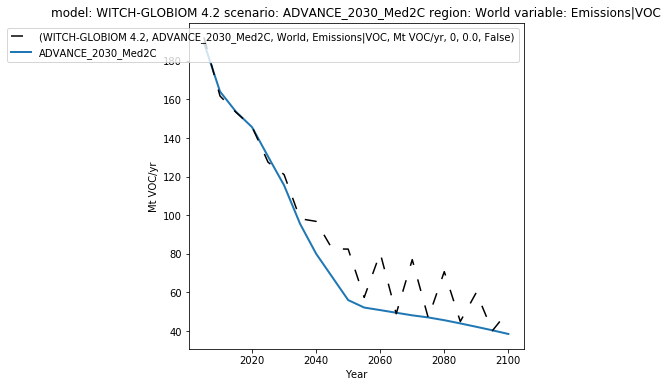

In [34]:
# NBVAL_IGNORE_OUTPUT
pkwargs = {"color": "scenario", "linewidth": 2}
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
filler_data.filter(variable='Emissions|VOC', ).line_plot(ax=ax, **pkwargs)
infilled_quantile.filter(variable='Emissions|VOC').line_plot(ax=ax, color="black", linestyle="--", dashes=(8, 10))

By increasing the windows number, we can get a higher fidelity - at the cost of more computational power and less averaging over different datapoints. 

In [35]:
# NBVAL_IGNORE_OUTPUT
# With a lower window number, the deviations become clearer
self_filler_low_w = self_cruncher.derive_relationship("Emissions|VOC", ["Emissions|VOC"], nwindows=2)
infilled_low_w = self_filler_low_w(filler_data)
infilled_low_w.head()

,model,scenario,region,variable,unit,year,meta,subannual,value
0,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2005,0,0.0,183.151752
1,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2010,0,0.0,173.061130
2,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2015,0,0.0,162.837011
3,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2020,0,0.0,160.773780
4,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2025,0,0.0,146.316428


In [36]:
# NBVAL_IGNORE_OUTPUT
# Higher window numbers mean that we weight data with the exact same x-value more highly, recovering the original relation
self_filler_high_w = self_cruncher.derive_relationship("Emissions|VOC", ["Emissions|VOC"], nwindows=30)
infilled_high_w = self_filler_high_w(filler_data)
infilled_high_w.head()

,model,scenario,region,variable,unit,year,meta,subannual,value
0,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2005,0,0.0,190.326512
1,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2010,0,0.0,164.168245
2,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2015,0,0.0,153.575866
3,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2020,0,0.0,144.936194
4,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2025,0,0.0,129.585687


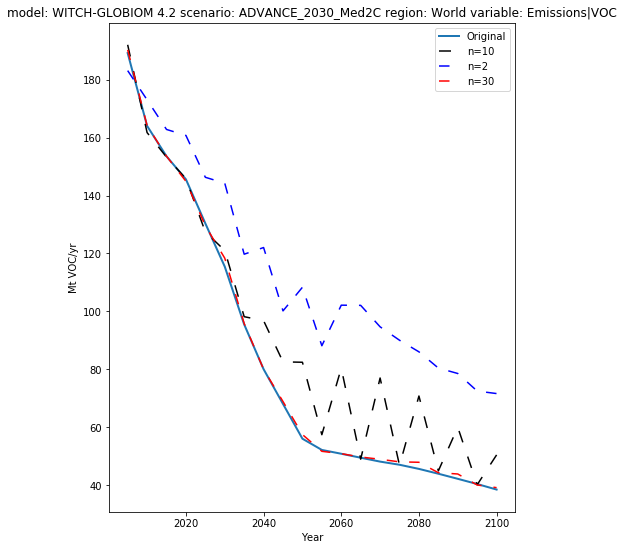

In [37]:
# NBVAL_IGNORE_OUTPUT
# Here the lower window count (orange) results in large deviations whereas the high window case (red) provides a close match. 
pkwargs = {"color": "scenario", "linewidth": 2}
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
# This line illustrates the background data informing the deviations (but confuses the plots). 
# Re-add it in place of the legend line if desired
#sr15_data.filter(variable='Emissions|VOC',).line_plot(ax=ax, linewidth=0.1)

filler_data.filter(variable='Emissions|VOC', ).line_plot(ax=ax, **pkwargs)
infilled_quantile.filter(variable='Emissions|VOC').line_plot(ax=ax, color="black", linestyle="--", dashes=(8, 10))
infilled_low_w.line_plot(ax=ax, color="blue", linestyle="--", dashes=(7, 8))
infilled_high_w.line_plot(ax=ax, color="red", linestyle="--", dashes=(7, 8))
plt.legend(['Original', 'n=10', 'n=2', 'n=30'])